<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facts extraction with AILA data and BERT

- for training: the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
- for test: additional train documents from AILA 2021;


### Installing dependencies

In [1]:
!pip install transformers

In [2]:
!pip install datasets

### Loading dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = "/content/gdrive/MyDrive/"

Mounted at /content/gdrive


In [4]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}fact_extraction_AILA/train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}fact_extraction_AILA/test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

In [5]:
from os import listdir
import pandas as pd

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary.
  """
  sentences = []
  labels = []
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        names=['sentence', 'label'])
    sentences.extend(df['sentence'].to_list())
    labels.extend(df['label'].to_list())
  return {'sentences': sentences, 'labels': labels}

dic_train = read_docs(train_dir)

### Tokenizer and Dataset preparation

In [6]:
from transformers import AutoTokenizer

model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [7]:
from datasets import Dataset

def tokenize_function(ds):
  return tokenizer(ds['sentence'], padding='max_length', truncation=True)

def create_dataset(dic_data):
  dic_ = {
      'label' : [1 if s == 'Facts' else 0 for s in dic_data['labels']], 
      'sentence' : dic_data['sentences']
  }
  ds = Dataset.from_dict(dic_)
  ds = ds.map(tokenize_function, batched=True)
  ds.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
  return ds

ds_train = create_dataset(dic_train)

  0%|          | 0/10 [00:00<?, ?ba/s]

In [8]:
ds_train

Dataset({
    features: ['label', 'sentence', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 9380
})

### Model and fine-tuning

In [9]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [11]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
  output_dir='results', 
  num_train_epochs=3, 
  per_device_train_batch_size=8, 
  per_device_eval_batch_size=8, 
  evaluation_strategy='no'
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=ds_train,
  eval_dataset=ds_train
)

In [12]:
%%time

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9380
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3519


Step,Training Loss
500,0.478400
1000,0.428600
1500,0.395000
2000,0.370400
2500,0.351900
3000,0.282600
3500,0.278100


Saving model checkpoint to results/checkpoint-500
Configuration saved in results/checkpoint-500/config.json
Model weights saved in results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to results/checkpoint-1000
Configuration saved in results/checkpoint-1000/config.json
Model weights saved in results/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to results/checkpoint-1500
Configuration saved in results/checkpoint-1500/config.json
Model weights saved in results/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to results/checkpoint-2000
Configuration saved in results/checkpoint-2000/config.json
Model weights saved in results/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to results/checkpoint-2500
Configuration saved in results/checkpoint-2500/config.json
Model weights saved in results/checkpoint-2500/pytorch_model.bin
Saving model checkpoint to results/checkpoint-3000
Configuration saved in results/checkpoint-3000/config.json
Model weights save

CPU times: user 1h 21min 1s, sys: 6min 40s, total: 1h 27min 41s
Wall time: 1h 27min 45s


TrainOutput(global_step=3519, training_loss=0.36827101664097345, metrics={'train_runtime': 5264.9865, 'train_samples_per_second': 5.345, 'train_steps_per_second': 0.668, 'total_flos': 7403945097830400.0, 'train_loss': 0.36827101664097345, 'epoch': 3.0})

### Saving trained model

In [15]:
model_directory = "results/trained_model"
tokenizer.save_pretrained(model_directory)
model.save_pretrained(model_directory)

tokenizer config file saved in results/trained_model/tokenizer_config.json
Special tokens file saved in results/trained_model/special_tokens_map.json
Configuration saved in results/trained_model/config.json
Model weights saved in results/trained_model/pytorch_model.bin


In [16]:
!tar -czvf {g_drive_dir}fact_extraction_AILA/bert-trained.tar.gz results/trained_model/

results/trained_model/
results/trained_model/tokenizer.json
results/trained_model/vocab.txt
results/trained_model/special_tokens_map.json
results/trained_model/config.json
results/trained_model/tokenizer_config.json
results/trained_model/pytorch_model.bin


### Evaluation

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import numpy as np

def evaluate(ds):
  logits, target_ids, _  = trainer.predict(ds)
  predicted_ids = np.argmax(logits, axis=-1)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    target_ids, 
    predicted_ids, 
    average='binary', 
    pos_label=1, 
    zero_division=0)
  print(f'Precision: {t_metrics[0]:.4f}')
  print(f'Recall:    {t_metrics[1]:.4f}')
  print(f'F-score:   {t_metrics[2]:.4f}')
  # Confusion matrix
  cm = confusion_matrix(
    target_ids, 
    predicted_ids)
  ConfusionMatrixDisplay(cm, display_labels=['Other', 'Facts']).plot()


  0%|          | 0/2 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1673
  Batch size = 8


Precision: 0.6928
Recall:    0.6306
F-score:   0.6602


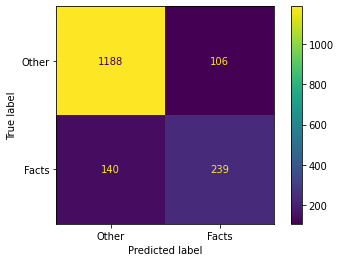

In [14]:
dic_test = read_docs(test_dir)
ds_test = create_dataset(dic_test)
evaluate(ds_test)